- Tensorflow dataset
- Simple LSTM Network
- Long sequences to short chunks

In [1]:
! pip install pandas

    100% |████████████████████████████████| 10.0MB 3.0MB/s eta 0:00:01
    100% |████████████████████████████████| 512kB 6.6MB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install mne

    100% |████████████████████████████████| 6.6MB 3.1MB/s ta 0:00:011
    100% |████████████████████████████████| 26.0MB 1.8MB/s eta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
! pip install scikit-learn

    100% |████████████████████████████████| 7.0MB 2.7MB/s ta 0:00:011
    100% |████████████████████████████████| 296kB 9.9MB/s eta 0:00:01
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
! pip install seaborn

    100% |████████████████████████████████| 225kB 3.4MB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
! pip install keras

    100% |████████████████████████████████| 378kB 1.9MB/s ta 0:00:01
    100% |████████████████████████████████| 276kB 3.3MB/s ta 0:00:011
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
! pip install tqdm

    100% |████████████████████████████████| 61kB 534kB/s ta 0:00:011
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import os

In [6]:
import keras

Using TensorFlow backend.


In [7]:
import seaborn as sns

In [8]:
from collections import Counter

In [9]:
from tqdm import tqdm_notebook

In [10]:
from tqdm.notebook import tqdm

Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [11]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [12]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [13]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [14]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [15]:
train_df = append_file_info(train_df)

In [16]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [17]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    return df[df["full_path"].apply(lambda x: "01_tcp_ar" in x)].copy()

In [18]:
train_df = attach_files(train_df, "train")

In [19]:
val_df = attach_files(val_df, "dev")

# Remove bckg files

In [20]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [21]:
train_df = remove_bckg_files(train_df)

In [22]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [23]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR")
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        edf_data.append(data)
        
    return pd.DataFrame(edf_data)

In [24]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [25]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [26]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [27]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [28]:
all_channels = dict(counter.most_common())

In [29]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [30]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [31]:
len(CHANNELS)

21

# Calculate chunk size

In [32]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

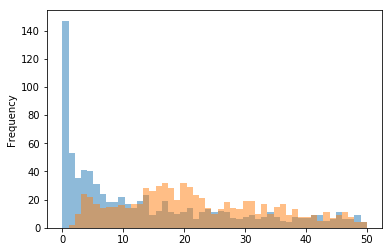

In [33]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [34]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

In [35]:
BATCH_SIZE = 32

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [36]:
def get_data(df, file, channels=CHANNELS, chunk_size=CHUNK_TIME):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:]
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
#     scaler = StandardScaler() 
#     data = scaler.fit_transform(data.T).T
    
    return data, events

In [37]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file in files:
        data, events = get_data(df, file)
        total_data.append(data)
        total_events.append(events)
    
    min_length = min([e.shape[0] for e in total_events])
    truncated_length = (min_length // chunk_size) * chunk_size
    total_data = [d[:, :truncated_length] for d in total_data]
    total_events = [e[:truncated_length] for e in total_events]
    
    return np.stack(total_data), np.stack(total_events)

In [38]:
def iterate_chunks(data, events, chunk_size=CHUNK_TIME, batch_size=BATCH_SIZE):
    max_time = max([e.shape[0] for e in events])
    while True:
        chunk_indices = range(0, max_time - chunk_size, chunk_size // 10)
        chunk_indices = np.random.choice(chunk_indices, len(chunk_indices), replace=False)
        
        for chunk_start in chunk_indices:
            data_chunk = [d[:, chunk_start:chunk_start + chunk_size].T for d in data]
            data_chunk = [np.abs(np.fft.fft(chunk, axis=0))[:chunk_size // 2] for chunk in data_chunk]
            labels_chunk = [e[chunk_start:chunk_start + chunk_size].mean() > 0 for e in events]
            yield np.stack(data_chunk).reshape(batch_size, -1), np.stack(labels_chunk)

In [39]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df["full_path"].unique()
    files = np.random.choice(files, len(files), replace=False)
    for files in zip(*[iter(files)]*batch_size):
        yield files

In [40]:
# next(iterate_files(train_df))

In [41]:
# data, events = get_data(train_df, files[0])

In [42]:
files = train_df["full_path"].value_counts().index[0:32]
data, events = get_data_multiple(train_df, files)

In [43]:
iterator = iterate_chunks(data, events)

In [44]:
data_chunk, labels_chunk = next(iterator)

In [45]:
data_chunk.shape

(32, 2625)

# Model creation

In [46]:
RNN_SIZE = 128
NUM_EPOCHS = 10

In [47]:
CNN_FILTERS = (128, 256, 512, 512)

In [48]:
HIDDEN_DIMS = (1024, 1024, )

In [51]:
eeg_input = keras.layers.Input(shape=(CHUNK_TIME // 2 * len(CHANNELS), ), name="eeg")

In [52]:
# feature_extractor = eeg_input

# for cnn_filters in CNN_FILTERS:
#     feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
#     feature_extractor = keras.layers.MaxPool1D(pool_size=2, padding="same")(feature_extractor)

In [53]:
# flatten = keras.layers.Flatten()(feature_extractor)
# out = flatten
out = eeg_input

for hidden_dim in HIDDEN_DIMS:
    out = keras.layers.Dropout(0.5)(out)
    out = keras.layers.Dense(hidden_dim, activation="relu")(out)
    
out = keras.layers.Dense(1, activation="sigmoid", name="model_output")(out)
model = keras.models.Model(inputs=[eeg_input], outputs=[out])

Instructions for updating:
Colocations handled automatically by placer.


In [54]:
# import tensorflow as tf
# from keras.layers import Dense,Activation,Dropout
# from keras.layers import LSTM,Bidirectional #could try TimeDistributed(Dense(...))
# from keras.models import Sequential, load_model
# from keras import optimizers,regularizers
# from keras.layers.normalization import BatchNormalization
# import keras.backend.tensorflow_backend as KTF

# model = Sequential()
# model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), batch_input_shape=(BATCH_SIZE, CHUNK_TIME // 2, len(CHANNELS))))
# model.add(Bidirectional(LSTM(32, return_sequences=False, stateful=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

In [55]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [56]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [57]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# Overfit on small dataset

- TODO add validation
- TODO make batch
- TODO speed up iteration

TODO make model converge on this batch

In [58]:
generator = iterate_chunks(data, events)

In [59]:
next(generator)
x, y_end = next(generator)

In [60]:
y_end.sum() / (y_end > -1).sum()

0.46875

In [61]:
x.shape[0]

32

In [62]:
model.predict(x)[3].mean()

0.49998024

In [63]:
model.evaluate(x, y_end)

32/32 [==============================] - 0s 1ms/step


[0.6929494142532349, 0.53125, 0.06666667014360428, 0.5]

In [64]:
# model.fit(x, y_end, batch_size=x.shape[0], epochs=1000)

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [65]:
def number_of_chunks(size):
    # TODO Get rid of this hack
    return (size // CHUNK_TIME - 1) * 10

In [66]:
from itertools import repeat

In [142]:
for epoch in tqdm(range(1)):
    for train_files, val_files in tqdm_notebook(list(zip(iterate_files(train_df), iterate_files(val_df)))):
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = iterate_chunks(train_data, train_events)

        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = iterate_chunks(val_data, val_events)

        model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=number_of_chunks(train_events[0].shape[0]) * 10,
            validation_data=val_generator,
            validation_steps=number_of_chunks(val_events[0].shape[0])
        )     
#         break
#     break

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch 1/1
690/690 [==============================] - 26s 37ms/step - loss: 0.2657 - accuracy: 0.9058 - recall_m: 0.8105 - precision_m: 0.8460 - val_loss: 0.6315 - val_accuracy: 0.7296 - val_recall_m: 0.4414 - val_precision_m: 0.3826
Epoch 1/1
810/810 [==============================] - 25s 31ms/step - loss: 0.2653 - accuracy: 0.8866 - recall_m: 0.7452 - precision_m: 0.8343 - val_loss: 1.8319 - val_accuracy: 0.7660 - val_recall_m: 0.5682 - val_precision_m: 0.2744
Epoch 1/1
1830/1830 [==============================] - 35s 19ms/step - loss: 0.4918 - accuracy: 0.8795 - recall_m: 0.6337 - precision_m: 0.8038 - val_loss: 0.4804 - val_accuracy: 0.7836 - val_recall_m: 0.2443 - val_precision_m: 0.2516
Epoch 1/1
980/980 [==============================] - 26s 27ms/step - loss: 0.2655 - accuracy: 0.9260 - recall_m: 0.7305 - precision_m: 0.9103 - val_loss: 0.8987 - val_accuracy: 0.7775 - val_recall_m: 0.2615 - val_precision_m: 0.2902
Epoch 1/1
2840/2840 [==============================] - 27s 9ms/ste

- Почему модель переобучается уже на FFT?
- Почему предварительная свертка работает хуже?
- Почему очень низкий precision?
- Почему на каждой итерации получается очень разный лосс, хотя файл тот же самый?

# Prediction

In [96]:
# val_files = next(iterate_files(train_df))

In [143]:
test_data, test_events = val_data, val_events

In [144]:
model.reset_states()

predicted_states = []
true_states = []

for (d, true_state), _ in zip(iterate_chunks(test_data, test_events), range(100)):
    current_state = model.predict(d)
    predicted_states.append(current_state)
    true_states.append(true_state)

In [145]:
all_true_states = np.vstack(true_states)

In [146]:
all_true_states.shape

(100, 32)

In [147]:
all_predicted_states = np.hstack(predicted_states).T

In [148]:
all_predicted_states.shape

(100, 32)

In [149]:
(all_true_states > 0.5).sum() / (all_true_states > -1).sum()

0.251875

In [150]:
nonzero_index = 1

In [151]:
pred = np.squeeze(all_predicted_states[nonzero_index])
true = np.squeeze(all_true_states[nonzero_index])

In [152]:
import matplotlib.pyplot as plt

In [153]:
pred[true < 0.5].mean()

0.28168857

In [154]:
pred[true > 0.5]

array([0.25538498, 0.00647986, 0.7172562 , 0.07342881, 0.9589976 ,
       0.1476363 , 0.03447622, 0.95477676], dtype=float32)

In [155]:
from sklearn.metrics import precision_score, recall_score

In [156]:
precision_score(true, pred > 0.5)

0.3333333333333333

Т.е. большое количество false positives

In [157]:
recall_score(true, pred > 0.5)

0.375

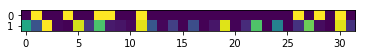

In [158]:
plt.imshow(np.stack([true.astype(float), pred]))

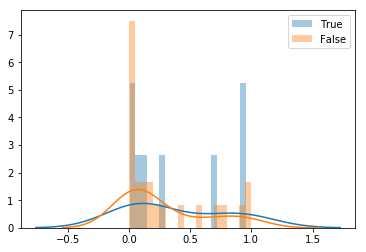

In [159]:
sns.distplot(pred[true > 0.5], label="True", bins=20)
sns.distplot(pred[true < 0.5], label="False", bins=20)
plt.legend()
# plt.xlim(0, 0.02)

That was fun but very frustrating towards the end.  For what it's worth, I used only spectral features (fft over 30s and 60s intervals, overlapped 50%).  The secret weapon was linear regression - you could get to about 0.85 on the leaderboard with straight LR, post scaled through a logistic function to (0,1) interval.  No networks, trees, SVMs, RBMs, etc. required.  Because LR is superfast and can be inverted (i.e. you can back-process to see what features it is scaling up, and what features it ignores)  I found some good feature sets.  It is also very hard to overtrain.  The general best featuresets were 1Hz bands from 0-50 Hz and then 5-10Hz bands up to 180Hz.  All data was filtered for 60Hz + harmonics.  I did use some networks (ELM ensembles) to get a couple of extra points.  The final solution was computed on my laptop  (a 2010 MacBook Air).  No AWS required.  Now I just hope I can reproduce the damn result for the organizers!